# (07) Readout: Separable

**Motivation**: Did not work. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Reservoir + Readout

In [2]:
vae = VAE(ConfigVAE(
    n_kers=4,
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=7,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(
    model=vae,
    cfg=ConfigTrainVAE(
        lr=0.002, batch_size=500, epochs=2000, grad_clip=1000,
        lambda_anneal=True, lambda_init=1e-7, lambda_norm=1e-2,
        kl_beta=0.25, kl_anneal_cycles=1, kl_anneal_portion=0.3,
        scheduler_kws={'T_max': 650.0, 'eta_min': 1e-05},
    ),
    device='cuda:2',
)
vae.cfg.total_latents()

210

In [3]:
from readout.readout import Readout3D, ConfigReadout

In [4]:
n_ftrs_enc, n_ftrs_dec = vae.ftr_sizes()
cfg = ConfigReadout(n_ftrs_enc, pool='max')
readout = Readout3D(cfg).to(tr.device)
readout.print()

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  Readout3D  |   5.7 K    |
|     ---     |    ---     |
|      fc     |   5.3 K    |
|    kernel   |    338     |
+-------------+------------+

##### Load a neuron

In [5]:
from base.dataset import setup_supervised_data, setup_repeat_data, time_embed

file = h5py.File(cfg.h_file, 'r')
expt = 'clu096'
grp = file[expt]

In [6]:
scale = 2.25
hf_kws = {
    'size': 19,
    'sres': 1,
    'radius': 6,
}
hf = HyperFlow(
    params=np.array(grp['hyperflow'])[:, 2:],
    center=np.array(grp['hyperflow'])[:, :2],
    **hf_kws,
)
stim = hf.compute_hyperflow()
spks = np.array(grp['spks'], dtype=float)
mask = ~np.array(grp['badspks'], dtype=bool)
good = np.where(mask)[0]
# src, tgt = setup_supervised_data(lags, good, stim, spks)
stim_r, spks_r, intvl = setup_repeat_data(grp, lags=None, hf_kws=hf_kws)
stim_scale = np.max(np.abs(stim))
stim *= scale / stim_scale
if stim_r is not None:
    stim_r *= scale / stim_scale
stim.shape, stim_r.shape

((28800, 2, 19, 19), (12000, 2, 19, 19))

In [7]:
np.round(np.quantile(stim.ravel(), [0.5, 0.95, 0.97, 0.99]), 2)

array([0.  , 0.38, 0.51, 0.76])

### Get ready to fit

In [8]:
cfg = ConfigReadout(n_ftrs_enc, act_fn='none', dropout=0.0, n_lags=13)
readout = Readout3D(cfg).to(tr.device)

optim = torch.optim.AdamW(readout.parameters(), lr=0.001, weight_decay=0.01)
optim_schedule = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, T_max=10000, eta_min=1e-5)

In [9]:
print(readout)
readout.print()

Readout3D(
  (relu): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
  (criterion): PoissonNLLLoss()
  (fc): Linear(in_features=5312, out_features=1, bias=True)
  (kernel): Conv3d(1, 1, kernel_size=(4, 4, 13), stride=(1, 1, 1), padding=(0, 0, 12))
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  Readout3D  |   5.5 K    |
|     ---     |    ---     |
|      fc     |   5.3 K    |
|    kernel   |    210     |
+-------------+------------+

In [10]:
tau = 1000
valid_inds = np.arange(len(stim) - tau)
rng = get_rng()

In [11]:
from base.utils_model import AvgrageMeter
nll = AvgrageMeter()

In [12]:
lr_all = []
loss_all = []

readout.train()

n_iters = range(10000)
pbar = tqdm(n_iters)
for _ in pbar:
    i = rng.choice(valid_inds)
    timepoints = range(i, i + tau)
    m = mask[timepoints]
    m[:readout.cfg.n_lags] = 0.0
    if not m.sum():
        continue
    x = stim[timepoints]
    y = spks[timepoints]

    x, y, m = tr.to([x, y, m])
    *_, ftr = vae.xtract_ftr(x, full=True)

    pred = readout(ftr['enc'])
    loss = readout.criterion(pred, y)
    loss = torch.sum(loss * m) / m.sum()

    optim.zero_grad()
    loss.backward()
    optim.step()
    optim_schedule.step()
    
    nll.update(loss.item())
    loss_all.append(loss.item())
    lr_all.append(optim.param_groups[0]['lr'])
    pbar.set_description(f"nll = {nll.avg:0.6f}, lr = {lr_all[-1]:0.2g}")

  0%|          | 0/10000 [00:00<?, ?it/s]

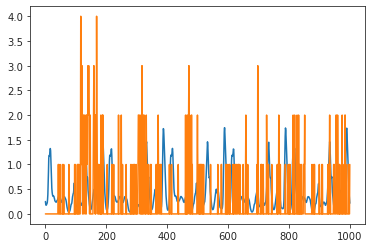

In [20]:
if readout.criterion.log_input:
    r_pred = to_np(pred.exp().ravel())
else:
    r_pred = to_np(pred.ravel())
r_obs = to_np(y.ravel())
plt.plot(r_pred)
plt.plot(r_obs)

In [21]:
sp_stats.pearsonr(r_pred, r_obs)

(0.01294228895046084, 0.6827037980929888)

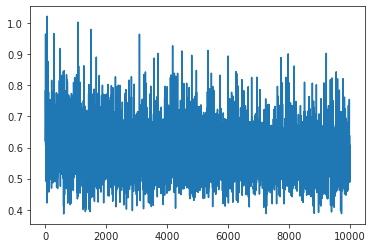

In [22]:
plt.plot(loss_all)

nll = 0.585475, lr = 1e-05: 100%|██████████| 10000/10000 [52:28<00:00,  3.18it/s] 


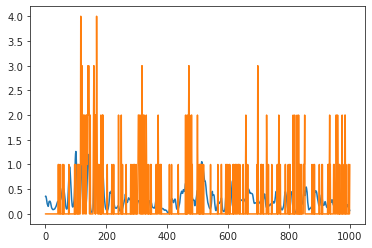

(0.2795849216764322, 2.0515174564335051e-19)

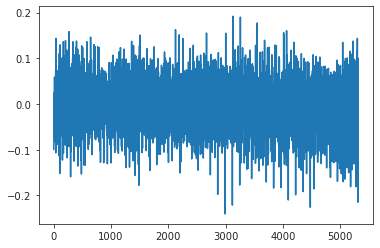

In [23]:
w = to_np(readout.fc.weight)
plt.plot(w.ravel());

In [24]:
w = to_np(readout.kernel.weight.squeeze())
w.shape

(4, 4, 13)

In [25]:
u, s, v = sp_lin.svd(flatten_arr(w))
s *= 100 / s.sum()
s

array([30.619907 , 14.316688 , 10.187466 ,  8.742496 ,  7.3852415,
        6.0761623,  5.5939846,  5.2351265,  3.600304 ,  2.6474044,
        2.2942114,  2.0266666,  1.2743596], dtype=float32)

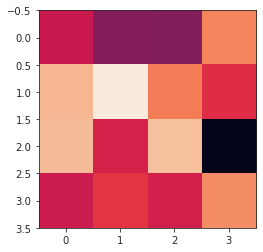

In [26]:
plt.imshow(u[:, 0].reshape(4, 4))

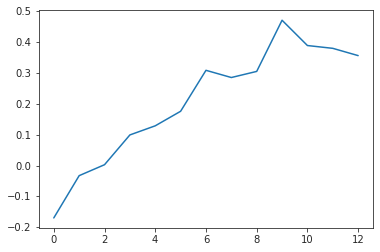

In [27]:
plt.plot(v[0])

In [33]:
readout.eval()

timepoints = range(1000)
x = tr.to(stim_r[timepoints])
*_, ftr = vae.xtract_ftr(x, full=True)
pred = readout(ftr['enc'])

In [34]:
if readout.criterion.log_input:
    r_pred = to_np(pred[intvl].ravel().exp())
else:
    r_pred = to_np(pred[intvl].ravel())

r_obs = np.nanmean(spks_r[0], 0)
r2 = sk_metric.r2_score(
    y_true=r_obs,
    y_pred=r_pred,
) * 100

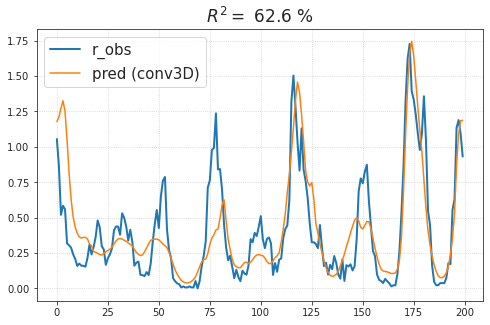

In [36]:
fig, ax = create_figure(1, 1, (8, 5))
plt.plot(r_obs, color='C0', lw=2, label='r_obs')
plt.plot(r_pred, color='C1', label='pred (conv3D)')
plt.title(r"$R^2 = $" + f" {r2:0.1f} %", fontsize=17)
plt.legend(fontsize=15)
ax.grid()
plt.show()

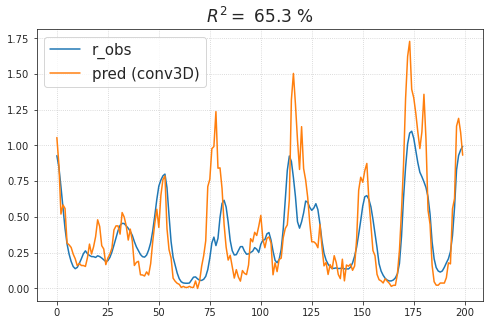

In [45]:
from readout.readout import Readout3D, ReadoutSep, nn

cfg = ConfigReadout(
    n_ftrs_enc,
    act_fn='learned_softplus',
    pool='max',
    dropout=0.0,
    n_lags=21,
)
readout = ReadoutSep(cfg).to(tr.device)

optim = torch.optim.AdamW(readout.parameters(), lr=0.01, weight_decay=0.01)
optim_schedule = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, T_max=10000, eta_min=1e-5)

In [46]:
print(readout)
readout.print()

ReadoutSep(
  (relu): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
  (act_fn): LearnedSoftPlus()
  (criterion): PoissonNLLLoss()
  (fc): Linear(in_features=5312, out_features=1, bias=True)
  (tker): Conv1D(1, 1, kernel_size=(21,), stride=(1,), padding=(20,))
  (sker): Linear(in_features=16, out_features=1, bias=True)
  (l1_weight): SmoothL1Loss()
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  ReadoutSep |   5.4 K    |
|     ---     |    ---     |
|    act_fn   |     1      |
|      fc     |   5.3 K    |
|     tker    |     23     |
|     sker    |     18     |
+-------------+------------+

In [47]:
tau = 500
valid_inds = np.arange(len(stim) - tau)
rng = get_rng()

In [48]:
from base.utils_model import AvgrageMeter

In [49]:
lr_all = []
loss_all = []

readout.train()

n_iters = range(10000)
pbar = tqdm(n_iters)
for e in pbar:
    if e % 200 == 0:
        if e > 0:
            loss_all.append(nll.avg)
        nll = AvgrageMeter()
    i = rng.choice(valid_inds)
    timepoints = range(i, i + tau)
    m = mask[timepoints]
    m[:readout.cfg.n_lags] = 0.0
    if not m.sum():
        continue
    x = stim[timepoints]
    y = spks[timepoints]

    x, y, m = tr.to([x, y, m])
    *_, ftr = vae.xtract_ftr(x, full=True)

    pred = readout(ftr['enc'])
    loss = readout.loss(pred, y, m)
    lowss_w = readout.loss_weight()
    loss += lowss_w.mul(0.01)

    optim.zero_grad()
    loss.backward()
    optim.step()
    optim_schedule.step()
    
    nll.update(loss.item())
    lr_all.append(optim.param_groups[0]['lr'])
    pbar.set_description(f"nll = {nll.avg:0.6f}, loss_w = {lowss_w:0.2g}, lr = {lr_all[-1]:0.2g}")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [50]:
## Learned Softplus

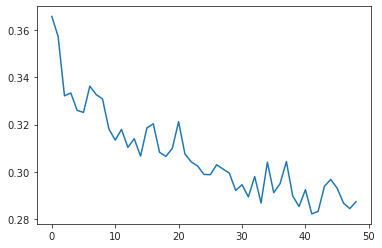

In [59]:
plt.plot(loss_all)

In [60]:
i = rng.choice(valid_inds)
timepoints = range(i, i + tau)
m = mask[timepoints]
m[:readout.cfg.n_lags] = 0.0
x = stim[timepoints]
y = spks[timepoints]

x, y, m = tr.to([x, y, m])
*_, ftr = vae.xtract_ftr(x, full=True)
pred = readout(ftr['enc'])

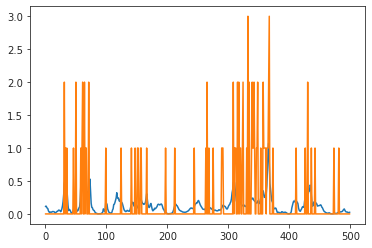

In [61]:
if readout.criterion.log_input:
    r_pred = to_np(pred.exp().ravel())
else:
    r_pred = to_np(pred.ravel())
r_obs = to_np(y.ravel())
plt.plot(r_pred)
plt.plot(r_obs)

In [62]:
sp_stats.pearsonr(r_pred, r_obs)

(0.4519051410203052, 1.5575342564162936e-26)

In [63]:
readout.eval()

timepoints = range(1000)
x = tr.to(stim_r[timepoints])
*_, ftr = vae.xtract_ftr(x, full=True)
pred = readout(ftr['enc'])

In [64]:
if readout.criterion.log_input:
    r_pred = to_np(pred[intvl].ravel().exp())
else:
    r_pred = to_np(pred[intvl].ravel())

r_obs = np.nanmean(spks_r[0], 0)
r2 = sk_metric.r2_score(
    y_true=r_obs,
    y_pred=r_pred,
) * 100

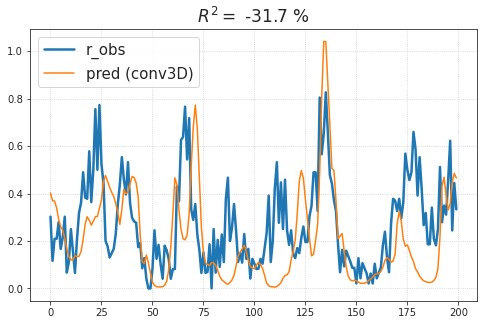

In [65]:
fig, ax = create_figure(1, 1, (8, 5))
plt.plot(r_obs, color='C0', lw=2.5, label='r_obs')
plt.plot(r_pred, color='C1', label='pred (conv3D)')
plt.title(r"$R^2 = $" + f" {r2:0.1f} %", fontsize=17)
plt.legend(fontsize=15)
ax.grid()
plt.show()

In [66]:
readout.sker.lognorm.exp(), readout.tker.lognorm.exp()

(tensor([1.0901], device='cuda:2', grad_fn=<ExpBackward0>),
 tensor([1.0925], device='cuda:2', grad_fn=<ExpBackward0>))

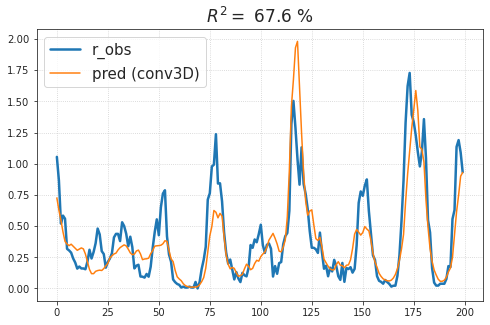

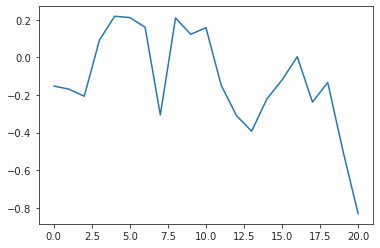

In [67]:
plt.plot(to_np(readout.tker.weight.squeeze()))

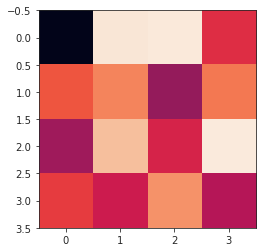

In [68]:
plt.imshow(to_np(readout.sker.weight.squeeze()).reshape(4, 4))

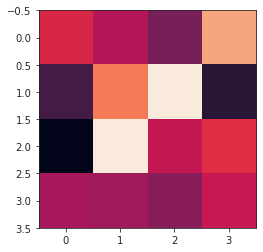

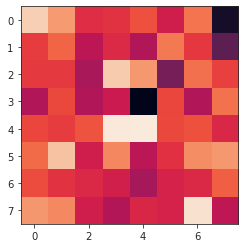

In [28]:
plt.imshow(to_np(readout.sker['8'].weight.squeeze()).reshape(8, 8))